In [1]:
import torch
from torch import nn as nn
import math
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from os import path
from math import ceil, floor
from torch_snippets import * # Contains functions to manipulate images -- avoids to import cv2, glob, etc.

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Load dataset filenames and separate them into training, validation, and test sets

In [2]:
train_perc  = 0.60
valid_perc  = 0.20
test_perc   = 0.20
file_ext    = "*.png" 
base_dir    = path.join("images", "corel") # base folder with dataset information
fileset = Glob(base_dir+'/'+file_ext) # it returns a list of filenames
num_train_samples = int(len(fileset)*train_perc)
num_valid_samples = int(len(fileset)*valid_perc)  
num_test_samples  = len(fileset) - num_train_samples - num_valid_samples 
from random import shuffle, seed; seed(10);
shuffle(fileset)
trainset = fileset[:num_train_samples]
validset = fileset[num_train_samples:num_train_samples+num_valid_samples]
testset  = fileset[num_train_samples+num_valid_samples:]
nclasses    = 6
model_name  = 'corel.pth'

### Define preprocessing and a class that reads, transforms, and returns images and labels as tuples of tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0, fillcolor=None, resample=None),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

class DatasetImage(Dataset): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)      

### Exemplify the execution of DatasetImage 

Number of images: 213
Images are 224x224x3
Class of the image:  2


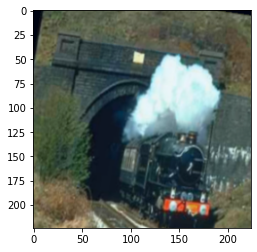

In [4]:
datatensor = DatasetImage(trainset, aug)
print("Number of images:", len(datatensor))
image, target = datatensor[80] # it executes getitem
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Create functions that return random batches from the filename lists in the training, validation, and test sets

In [5]:
batchsize = 32

def GetBatches(dataset, batchsize, transformation):
    datatensor = DatasetImage(dataset, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(trainset, batchsize, aug)  
validload = GetBatches(validset, batchsize, prep)
testload  = GetBatches(testset, batchsize, prep) 

In [6]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

List Of 2 items
	Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.623	Mean: -0.279	dtype: torch.float32
	Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 5.000	Mean: 1.969	dtype: torch.int64


### Define a ConvNet model compatible with the input_shape

In [7]:
# Since you have used prep above, you have changed the input image size to 3 x 224 x 224
nchannels   = 3
height      = 224
width       = 224
input_shape = (nchannels, height, width)

class CorelNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(CorelNet, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=(3, 3), 
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), padding=1, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), 
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), padding=1, stride=2)
        )

        #defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*64, out_features=512, bias=True),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(512, nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

### Create the model

In [8]:
model = CorelNet(input_shape, nclasses).to(device)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
├─Sequential: 1-2                        [-1, 6]                   --
|    └─Linear: 2-9                       [-1, 512]                 102,760,960
|    └─ReLU: 2-10                        [-1, 512]                 --
|    └─Dropout: 2-11                     [-1, 512]                 --


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
├─Sequential: 1-2                        [-1, 6]                   --
|    └─Linear: 2-9                       [-1, 512]                 102,760,960
|    └─ReLU: 2-10                        [-1, 512]                 --
|    └─Dropout: 2-11                     [-1, 512]                 --


### Train the model and visualize its training and validation loss curves

In [9]:
#defining training loop
def train(model, trainload, validload, criterion, optimizer, lr_scheduler, epochs, device):
    train_loss_list = []
    train_acc_list  = []
    valid_loss_list = []
    valid_acc_list  = []

    for epoch in range(epochs):
        #put the model in training mode
        model.train() 
        
        print('-' * batchsize)
        print('Epoch {}/{}'.format(epoch, epochs - 1))

        running_loss = 0.0
        running_corrects = 0.0
        n = 0

        number_of_batches = len(trainload)
        #run the model on a batch and compute mean loss and mean accuracy
        for batch_index, data in enumerate(iter(trainload)):
            inputs, labels = data

            #mode data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
                        
            #zeroe gradients
            optimizer.zero_grad()
            
            #do forward through the neural network
            outputs = model(inputs)
    
            #compute l2_regularization
            
            l2_regularization = 0
            for param in model.parameters():
                l2_regularization += torch.norm(param,2)
                
            
            #compute the loss
            loss = criterion(outputs, labels) + 0.001*l2_regularization
            
            #compute gradients
            loss.backward()

            #update weights
            optimizer.step()

            #accumulate label prediction information to calculate accuracy
            preds = torch.max(outputs, 1)[1]
            running_loss     += loss.detach().cpu()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).detach().cpu()
            n += outputs.size(0)

            print("\rBatch {}/{} ".format(batch_index, number_of_batches), end="")
    
        # compute and store mean loss and mean accuracy in their lists
        
        train_loss = running_loss/n
        train_acc  = running_corrects.double()/n
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        # compute and store mean loss and mean accuracy on the validation set
        valid_loss, valid_acc = test(model, validload, criterion, device)
                              
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        
        #count epochs
        lr_scheduler.step()
    
        print('Training: Loss {:.6f}, Acc {:.6f} Validation: Loss {:.6f}, Acc {:.6f}'.format(train_loss, \
                                                                                             train_acc, \
                                                                                             valid_loss, \
                                                                                             valid_acc))
        
    return(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)  

def test(model, dataload, criterion, device):
    #put model in evaluation mode
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0.0
        n = 0
    
        number_of_batches = len(dataload)
  
        #process all batches without gradients computation
        for batch_index, data in enumerate(iter(dataload)):
            inputs, labels = data

            #mode data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
             
            #do forward through model
            outputs = model(inputs)

            #calculate loss
            loss = criterion(outputs, labels)
      
            #accumulate information to calculate mean loss and mean accuracy
            preds             = torch.max(outputs, 1)[1]
            running_loss     += loss.detach().cpu()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).detach().cpu()
            n                += outputs.size(0)
        
            data_loss = running_loss/n
            data_acc  = running_corrects.double()/n
    
    return(data_loss, data_acc)   

# Define criterion and optimizer

criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99) 
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [10]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

nepochs = 25
history = train(model, trainload, validload, criterion, optimizer, lr_scheduler, nepochs, device)

--------------------------------
Epoch 0/24
Batch 6/7 Training: Loss 1.731192, Acc 0.361502 Validation: Loss 1.106574, Acc 0.619718
--------------------------------
Epoch 1/24
Batch 6/7 Training: Loss 1.220327, Acc 0.568075 Validation: Loss 0.784315, Acc 0.661972
--------------------------------
Epoch 2/24
Batch 6/7 Training: Loss 0.862482, Acc 0.737089 Validation: Loss 0.597438, Acc 0.816901
--------------------------------
Epoch 3/24
Batch 6/7 Training: Loss 0.705677, Acc 0.821596 Validation: Loss 0.432229, Acc 0.873239
--------------------------------
Epoch 4/24
Batch 6/7 Training: Loss 0.630862, Acc 0.840376 Validation: Loss 0.458437, Acc 0.845070
--------------------------------
Epoch 5/24
Batch 6/7 Training: Loss 0.552768, Acc 0.863850 Validation: Loss 0.395517, Acc 0.873239
--------------------------------
Epoch 6/24
Batch 6/7 Training: Loss 0.543732, Acc 0.859155 Validation: Loss 0.361839, Acc 0.887324
--------------------------------
Epoch 7/24
Batch 6/7 Training: Loss 0.49485

### Plot the results

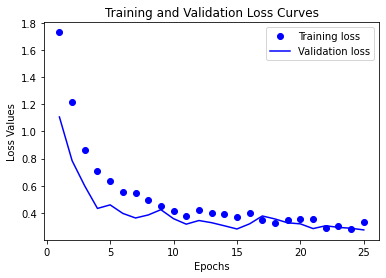

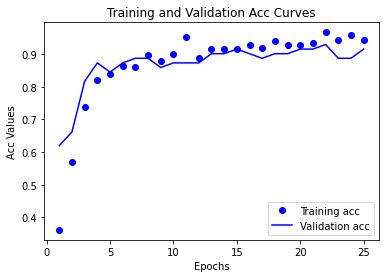

In [11]:
epochs = [ i for i in range(1, len(history[0])+1)]
plt.plot(epochs, history[0], 'bo', label='Training loss')
plt.plot(epochs, history[2], 'b', label='Validation loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.legend()
plt.show()
plt.clf
epochs = [ i for i in range(1, len(history[1])+1)]
plt.plot(epochs, history[1], 'bo', label='Training acc')
plt.plot(epochs, history[3], 'b', label='Validation acc')
plt.title('Training and Validation Acc Curves')
plt.xlabel('Epochs')
plt.ylabel('Acc Values')
plt.legend()
plt.show()

### Evaluate the model

In [12]:
(loss, acc) = test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss.to(device),acc.to(device)))

Loss: 0.315278 Acc: 0.859155


### Visualize activations

In [13]:
from collections import OrderedDict

In [14]:
# define a function to return activations of all layers. It depends on the model. 

def get_output_by_layer(model, x):
    #empty dict
    output_by_layer = OrderedDict()
  
    #get the input
    output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

    #for each layer of the feature extractor
    for layer_name, layer in model.features.named_children():
        #do forward through the layer
        x = layer.forward(x)
        #save the output
        output_by_layer["features-"+layer_name] = x.clone().detach().cpu().numpy()
  


    #transform features to a 2D tensor: you do not need to show this one
    x = x.flatten(start_dim=1)
    
    #for each layer of the classifier
    for layer_name, layer in model.classifier.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()
  
    #return output by layer
    return output_by_layer

#get the output activations from all layers and labels
def get_ouputs(model, dataload, device, model_name):
    outputs_by_layer = None
    all_labels = None

    #get a batch from the dataload
    for inputs, labels in dataload:
        #move inputs to the correct device
        inputs = inputs.to(device)
        labels = labels.clone().detach().cpu().numpy()
        
        #get outputs by layer
        outputs = get_output_by_layer(model, inputs)
            
        #save the outputs
        if outputs_by_layer is None:
            outputs_by_layer = outputs
            all_labels       = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate((outputs_by_layer[layer], outputs[layer]), axis=0)
            all_labels = np.concatenate((all_labels, labels))   

    return outputs_by_layer, all_labels

In [15]:
#import tsne to calculate projection
from sklearn.manifold import TSNE

# select a projection algorithm
reducer = TSNE(perplexity=20)

In [16]:
#maps from high dimension to 2D
def projection(outputs_by_layer, reducer):
    projection_by_layer = OrderedDict()

    for layer in outputs_by_layer:
        #get the output of layer
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        #map to 2D
        embedded = reducer.fit_transform(output)
        #save projection
        projection_by_layer[layer] = embedded
  
    return projection_by_layer

#plot the projection of the output of each layer
def create_visualization(projection_by_layer, all_labels):
  
    for layer in projection_by_layer:
        embedded = projection_by_layer[layer]
  
        fig = plt.figure(figsize=(8, 8))
        plt.scatter(embedded[:, 0], embedded[:, 1], c=all_labels, cmap=plt.get_cmap('tab10'))
        plt.axis("off")
        plt.title(layer)
        plt.colorbar()
        plt.show()
        plt.close(fig)

In [ ]:
outputs_by_layer, all_labels = get_ouputs(model, trainload, device, model_name)
projection_by_layer          = projection(outputs_by_layer, reducer)
create_visualization(projection_by_layer, all_labels)

### Visualize attention to explain a decision

In [ ]:
import cv2
import matplotlib.cm as cm

In [ ]:
# Define a function to get activations at the output of the feature extractor
def get_activations(model, x, device):
    # move input tensor x to the selected device
    x = x.to(device)
    # get activations after feature extraction
    x = model.features(x)
    
    #return output by layer
    return x

# Define a function to get the output of the model
def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval() 
    # move input tensor x to the selected device
    x = x.to(device) 
    # execute the model with gradients
    output = model(x)
    return(output)

def get_heatmap(model, x, device, model_name):
    # add one dimension (dim=0 must be the number of images)
    xin = x.unsqueeze(0)
    
    # get the output of the feature extractor 
    activ = get_activations(model, xin, device)

    # get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, xin, device)
    
    # get the most confident prediction
    pred   = logits.max(-1)[-1] 
    print("predicted label: ", pred.cpu().detach().numpy()[0]+1)
    
    # compute gradients with respect to the most confident prediction
    model.zero_grad() 
    logits[0,pred].backward(retain_graph=True) 
    
    # get the number of channels
    nchannels = activ.shape[1] 

    # only conv2D generates gradients, use the last one 
    conv_layername = '4'
    children       = model.features.named_children()
    
    for layer_name, layer in children:
        if layer_name == conv_layername:
            grad = layer.weight.grad
            # 64 filters of size 3x3 x 32 channels
            print("Shape of the gradient tensor: ", grad.shape)     
    
            # compute the weighted mean of the activations across channels using the mean value of the gradient 
            # of each filter parameter as weight. The result is a heatmap.
            for i in range(nchannels):
                activ[:,i,:,:] *= grad[i].mean()
            heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

            # convert to numpy, normalize, and resize to the input size
            heatmap = heatmap.squeeze(0).numpy()
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    
            return(heatmap)
    
    return(None)

def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0*heatmap)
    width   = int(heatmap.shape[1]*scale)
    height  = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.7 + img*0.3)
    plt.imshow(heatmap)
    plt.show()
    

# Show CAM for a given image
datatensor = DatasetImage(trainset, prep)
image, target = datatensor[80]

heatmap       = get_heatmap(model, image, device, model_name)
image         = image.permute(1,2,0).numpy()
image         = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image         = image.astype('uint8')
print("true label: ", target+1)

if (heatmap is not None):
    display_image_with_heatmap(image, heatmap, 1)

### Save the model

In [ ]:
torch.save(model.to('cpu').state_dict(), model_name)
model.to(device) # return model to device in case you want to execute previous cells